# Classificazione di traiettorie

In [9]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

trails_gdf = gpd.read_file('trails.shp')
trails_gdf.crs = "EPSG:4326"
trails_gdf.to_crs(epsg='3857', inplace=True)

In [10]:
trails_gdf

,profiles,geometry
0,foot-walking,"LINESTRING (1391904.738 5146242.155, 1391908.4..."
1,driving-car,"LINESTRING (1391904.738 5146242.155, 1391908.4..."
2,driving-car,"LINESTRING (1391904.738 5146242.155, 1391908.4..."
3,driving-car,"LINESTRING (1391904.738 5146242.155, 1391908.4..."
4,driving-car,"LINESTRING (1391904.738 5146242.155, 1391908.4..."
...,...,...
115,foot-walking,"LINESTRING (1391904.738 5146242.155, 1391898.6..."
116,foot-walking,"LINESTRING (1391904.738 5146242.155, 1391898.6..."
117,foot-walking,"LINESTRING (1391904.738 5146242.155, 1391908.4..."
118,foot-walking,"LINESTRING (1391904.738 5146242.155, 1391908.4..."


Ad una singola riga si può accedere attraverso l'attributo `iloc` e la posizione. 

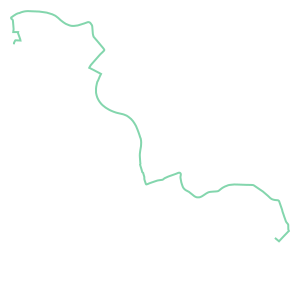

In [11]:
t = trails_gdf.iloc[3]

t['geometry']

Le features usate per la classificazione si basano sulla definizione di punti di riferimento dai quali calcoliamo la distanza dalla curva. In questo modo otteniamo una vettorizzazione della curva che può essere utilizzata come insieme di *features* da utilizzare negli algoritmi di apprendimento [[1]](https://arxiv.org/abs/1804.11284). 

Creeremo, per ogni traiettoria, un vettore denominato `img` di dimensione $d\times d$ dove `img[r,c]` rappresenta il punto `p` nello spazio di coordinate

```python
min_x + c*(max_x-min_x)/d, min_y + r*(max_y-min_y)/d
```

dove con `min_x, min_y, max_x, max_y` indichiamo il gli estremi del rettangolo che contiene tutte le traiettorie.

Il valore di `img[r,c]` sarà la distanza di `p` dalla curva. Quindi `img` sarà un vettore di $d^2$ features che può essere visto come una immagine che rappresenta la curva. In questo modo il problema di classificare percorsi diventa un problema di classificazione di immagini.

Il seguente codice crea il vettore `X` di immagini e il vettore `y` di etichette.

In [12]:
min_x, min_y, max_x, max_y = trails_gdf.total_bounds

dim = (50, 50)

img = np.zeros( dim )

# img[r][c] si riferisce al punto in posizione
# min_y + r*(max_y-min_y)/dim[0], min_x + r*(max_x-min_x)/dim[1] 

# img[r][c] contiene la distanza tra il punto rappresentato da r,c e la traccia

X = []
y = []

for _,t in trails_gdf.iterrows(): # itera sulle righe del GeoDataFrame, ritorna la coppia posizione, riga 
    p = 1 if t['profiles'] == 'foot-walking' else -1 # 
    y.append(p)
    for r in range(dim[0]):
        for c in range(dim[1]):
            p = Point( min_x + c*(max_x-min_x)/dim[1], min_y + r*(max_y-min_y)/dim[0]  )
            # Point è un tipo di dato definito nella libreria shapely,
            # t['geometry'] è una Linestring, il metodo distance restituisce la distanza tra due oggetti
            img[r,c] = p.distance(t['geometry'])
    row = img.reshape(dim[0]*dim[1]) # trasformiamo img in un array monodimensionale che sarà impilato ad X
    try:
        X = np.vstack([X, row])
    except ValueError:
        X = np.array(row)
        

X = X.T  # in X i vettorei delle features sono righe, a noi interessa che siano colonne
y = np.array(y)

Possiamo visualizzare l'ultimo valore di `img` con la libreria `matplotlib`.

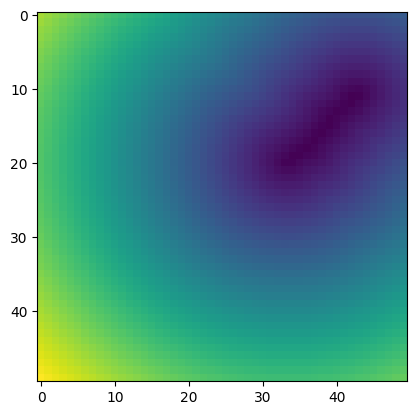

In [13]:
plt.imshow(img)

L'array può essere salvato in un file di testo e poi letto usando apposite funzioni di `numpy`.

In [14]:
np.savetxt('X.txt', X)

X = np.loadtxt('X.txt')

Proviamo ad addestrare un modello con l'algoritmo perceptrone testarlo con un test set.

In [24]:
X_train, y_train = X[:, :100], y[:100]
X_test, y_test = X[:, 20:], y[20:]

In [26]:
def perceptron( X, y, t=100):
    '''
        Input: X un array di dimensione d x n, y un array di 1xd.
            X[:i] è descrive il punto i
            t un upper bound sul numero di pass
        Ritorna a, a0 ovvero i coefficienti dell'iperpiano separatore
    '''
    d, n = X.shape
    
    a = np.zeros( (d, 1) ) # vettore colonna
    a0 = 0


    for j in range(t):
        finito = True
        for i in range(n):
            x = X[:,i:i+1] # colonna i, ovvero punto i
            if y[i]*(a.T.dot(x) + a0) <= 0:
                a = a + x*y[i]
                a0 = a0 + y[i]
                finito = False
        if finito:
            break
    return a, a0

In [27]:
a, a0 = perceptron(X_train, y_train)

La seguente funzione testa il modello con un insieme di esempi. Ritorna il vettore delle ipotesi.

In [28]:
def predict(X_test, a, a0):
    y_predict = []
    for i in range(X_test.shape[1]):
        x = X_test[:,i:i+1]
        y_predict.append(1 if (a.T.dot(x) + a0) > 0 else -1)
    return np.array(y_predict)

In [29]:
y_predict = predict(X_test, a, a0)

Confrontiamo `y_test` con `y_predict` per ottenere il numero di errori.

In [30]:
errors = (np.abs(y_predict -y_test)/2).sum()
print(errors)

19.0


Dal numero di errori è facile calcolare l'accuratezza.

In [31]:
accuracy = (X_test.shape[1]-errors)/X_test.shape[1]
print(accuracy)

0.81


La prossima funzione esegue una validazione incrociata dell'algoritmo

In [32]:
def x_validation(X, y, k = 10):
    '''
    X np.array che descrive le features di n esempi sulle n colonne
    y np.array delle etichette
    k numero di blocchi
    '''
    
    X_split = np.split(X, k, axis=1) # ritorna una lista di k sottovettori di X
    y_split = np.split(y, k)
    
    accuracies_sum = 0
    for i in range(k):
        X_test, y_test = X_split[i], y_split[i]
        # concatenate concatena gli array dentro una lista
        X_train, y_train = np.concatenate(X_split[:i]+X_split[i+1:], axis=1), np.concatenate(y_split[:i]+y_split[i+1:])    
        
        a, a0 = perceptron(X_train, y_train)
        
        y_predict = predict(X_test, a, a0)
        
        errors = (np.abs(y_predict-y_test)/2).sum()
        
        accuracy = (X_test.shape[1]-errors)/X_test.shape[1]
    
        accuracies_sum += accuracy
        
    return accuracies_sum/k

In [33]:
print(x_validation(X, y, k=6))

0.7416666666666666


Prendendo come features funzioni della distanza si ottengono risultati diversi. Ad esempio si può utilizzare la redice quadrata della distanza in questo modo

In [34]:
print(x_validation(X**0.5, y, k=6))

0.6333333333333334


La dimensione ridotta del dataset non ci consente di formulare conclusioni. Potrebbe essere interessante testare questo metodo usando dataset simili a questo disponibili in rete.